# Task 1 - Object Detection

1. Подготовить пайплайн для детекции животных (на выходной картинке у вас выделенная область с животными и класс, к которому он принадлежит (жираф, медведь, собака и тд).

In [ ]:
!pip install ultralytics

In [2]:
import cv2
from sklearn.base import BaseEstimator, TransformerMixin
from ultralytics import YOLO
from PIL import Image
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import time
import sys

In [106]:
class YOLODet(BaseEstimator, TransformerMixin):
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.classes_idx = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]   # ["bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe"]

    def transform(self, X):
        results = self.model.predict(X, classes=self.classes_idx)
        return results[0]

class Saver(BaseEstimator, TransformerMixin):
    def __init__(self, output_path = None):
        self.output_path = output_path  # Путь куда мы захотим сохранять наше изображение

    def transform(self, X):
        result = X
        img_detective = Image.fromarray(result.plot()[:,:, :: -1])
        if self.output_path:  # Если мы хотим сохранить изображение для дальнейшей его работы
            img_detective.save(self.output_path)
        return img_detective

In [107]:
pipeline = Pipeline([
    ('detector', YOLODet(model_path = 'yolov8m.pt')),
    ('saver', Saver())
])


0: 480x640 1 dog, 1 elephant, 29.4ms
Speed: 3.1ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


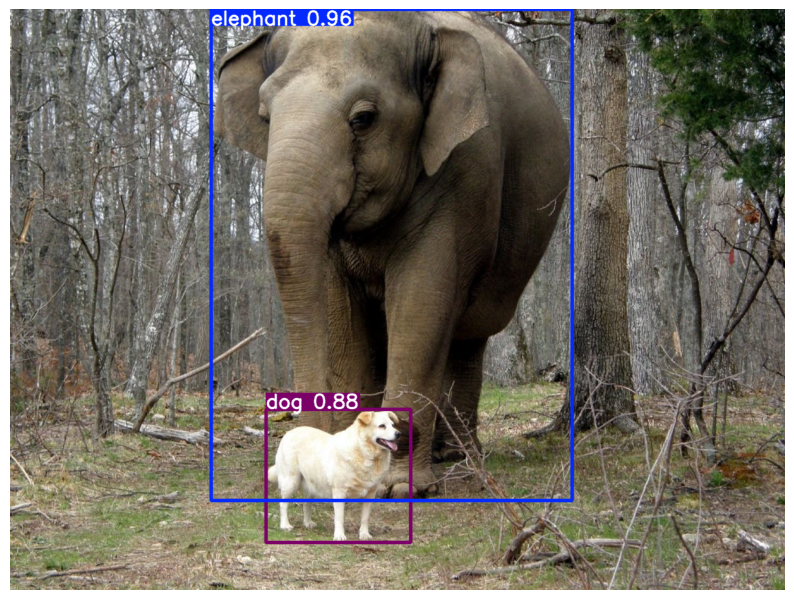

In [43]:
image_path = 'image1.jpg'
image = cv2.imread(image_path)

result_image = pipeline.transform(image)

plt.figure(figsize = (10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.show()


0: 640x640 1 zebra, 1 giraffe, 37.4ms
Speed: 3.5ms preprocess, 37.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


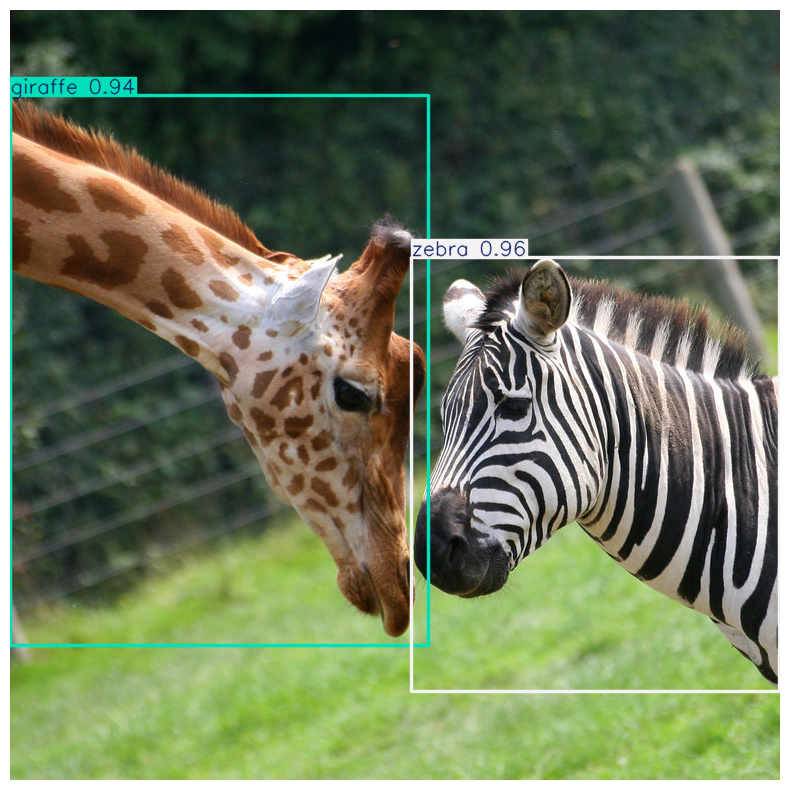

In [108]:
image_path = 'image2.jpg'
image = cv2.imread(image_path)

result_image = pipeline.transform(image)

plt.figure(figsize = (10, 10))
plt.imshow(result_image)
plt.axis('off')
plt.show()

# Task 2 - Face Recognition

2. Детекция и распознование лица партнера (на выходе пайплайна изображение (а лучше видео) где выделена область лица и подписано имя партнера, если это он/она, и если нет, то подписать не идентифицирован).

In [ ]:
!pip install opencv-python
!pip install dlib
!pip install tensorflow
!pip install face-recognition

## Images

In [44]:
import face_recognition
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pickle
import os

In [61]:
class KnownFaces(BaseEstimator, TransformerMixin):
    def __init__(self, known_faces_names=[]):
        self.known_faces_names = known_faces_names
        self.known_faces_encodings = {}

    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None, y=None):
        filename = X
        if not os.path.exists(filename): # Если файла не существует
            with open(filename, "wb") as f: # То создаем его
                pickle.dump(self.known_faces_encodings, f) # Сохрняя в него наш словарь
        else: # Если же существует
            with open(filename, "rb") as f:
                self.known_faces_encodings = pickle.load(f) # То загружаем из него словарь

        for name in self.known_faces_names:
            image_path = f'{name}.jpg'
            known_image = face_recognition.load_image_file(image_path)
            known_face_locations = face_recognition.face_locations(known_image)
            known_encoding = face_recognition.face_encodings(known_image, known_face_locations)[0]
            self.known_faces_encodings[name] = known_encoding

        with open(filename, "wb") as f:
            pickle.dump(self.known_faces_encodings, f) # Сохраняем измененный словарь в файл

        return self.known_faces_encodings



class FaceRecognition(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lst_known_faces_encodings = []
        self.lst_known_faces_names = []

    def fit(self, X=None, y=None):
        known_faces_encodings = X
        file_path = y
        self.image = face_recognition.load_image_file(file_path)

        for face_names in known_faces_encodings.keys():
            self.lst_known_faces_names.append(face_names)
        for face_encoding in known_faces_encodings.values():
            self.lst_known_faces_encodings.append(face_encoding)

        # Ищем лицо на кадре и извлекаем признаки
        self.face_locations = face_recognition.face_locations(self.image)
        self.face_encodings = face_recognition.face_encodings(self.image, self.face_locations)
        return self

    def transform(self, X=None, y=None):
        # Проходимся по каждому лицу
        for (top, right, bottom, left), face_encoding in zip(self.face_locations, self.face_encodings):
            # Сравниваем лицо с уже известными лицами
            matches = face_recognition.compare_faces(self.lst_known_faces_encodings, face_encoding)
            name = "Not Recognized"

            if True in matches:
                match_scores = [face_recognition.face_distance(self.lst_known_faces_encodings, face_encoding)]
                best_match_index = np.argmin(match_scores)
                name = self.lst_known_faces_names[best_match_index]

            # Рисуем прямоугольник и подпись
            cv2.rectangle(self.image, (left, top), (right, bottom), (0, 0, 255), 2)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(self.image, name, (left + 6, bottom - 6), font, 1, (255, 255, 255), 1)

        plt.imshow(self.image)
        plt.axis('off')
        plt.show()
        return

In [62]:
known_faces_names = ['Vladislav', 'Dasha'] # Названия изображений для загрузки, извлечения признаков и сохранения этих признаков в файл

pipeline = Pipeline([
    ('known_faces', KnownFaces(known_faces_names)),
    ('face_recognition', FaceRecognition())
])

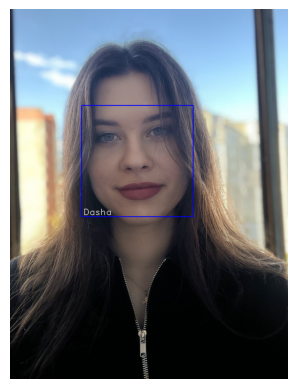

In [63]:
filename = 'known_faces.pickle'   # Название файла, в котором хранятся / будут храниться признаки лиц известных людей
image_path = 'Dasha_test.jpg'     # Путь к изображению

pipeline.fit_transform(filename, image_path)

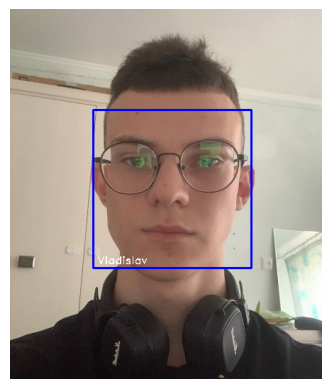

In [ ]:
filename = 'known_faces.pickle'   # Название файла, в котором хранятся / будут храниться признаки лиц известных людей
image_path = 'Vladislav.jpg'      # Путь к изображению

pipeline.fit_transform(filename, image_path)

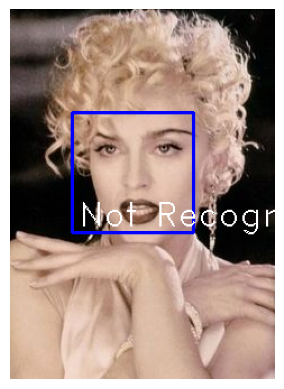

In [64]:
filename = 'known_faces.pickle'
image_path = 'Madonna.jpg'

pipeline.fit_transform(filename, image_path)

## Video

In [65]:
class KnownFaces(BaseEstimator, TransformerMixin):
    def __init__(self, known_faces_names=[]):
        self.known_faces_names = known_faces_names
        self.known_faces_encodings = {}

    def fit(self, X=None, y=None):
        return self

    def transform(self, X=None, y=None):
        filename = X
        if not os.path.exists(filename): # Если файла не существует
            with open(filename, "wb") as f: # То создаем его
                pickle.dump(self.known_faces_encodings, f) # Сохрняя в него наш словарь
        else: # Если же существует
            with open(filename, "rb") as f:
                self.known_faces_encodings = pickle.load(f) # То загружаем из него словарь

        for name in self.known_faces_names:
            image_path = f'{name}.jpg'
            known_image = face_recognition.load_image_file(image_path)
            known_face_locations = face_recognition.face_locations(known_image)
            known_encoding = face_recognition.face_encodings(known_image, known_face_locations)[0]
            self.known_faces_encodings[name] = known_encoding

        with open(filename, "wb") as f:
            pickle.dump(self.known_faces_encodings, f) # Сохраняем измененный словарь в файл

        return self.known_faces_encodings



class VideoFaceRecognition(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lst_known_faces_encodings = []
        self.lst_known_faces_names = []

    def fit(self, X=None, y=None):
        known_faces_encodings = X
        file_path = y
        cap = cv2.VideoCapture(file_path)

        for face_names in known_faces_encodings.keys():
            self.lst_known_faces_names.append(face_names)
        for face_encoding in known_faces_encodings.values():
            self.lst_known_faces_encodings.append(face_encoding)

        # Получение параметров видео для записи результата
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS)) # количество кадров в секунду
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') # 4-байтовый код, который используется для указания видеокодека
        # Сохранение видеофайла
        out = cv2.VideoWriter(f'output_video.mp4', fourcc, fps, (width, height))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Ищем лицо на кадре и извлекаем признаки
            face_locations = face_recognition.face_locations(frame)
            face_encodings = face_recognition.face_encodings(frame, face_locations)

            # Проходимся по каждому лицу
            for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
                # Сравниваем лицо с уже известными лицами
                matches = face_recognition.compare_faces(self.lst_known_faces_encodings, face_encoding)
                name = "Not Recognized"
                if True in matches:
                    match_scores = [face_recognition.face_distance(self.lst_known_faces_encodings, face_encoding)]
                    best_match_index = np.argmin(match_scores)
                    name = self.lst_known_faces_names[best_match_index]

                # Рисуем прямоугольник и подпись
                cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
                font = cv2.FONT_HERSHEY_DUPLEX
                cv2.putText(frame, name, (left + 6, bottom - 6), font, 0.5, (255, 255, 255), 1)

            # Записываем кадр в выходное видео
            out.write(frame)

        cap.release()
        out.release()

        print('Output video saved.')
        return self

    def transform(self, X=None, y=None):
        return

In [66]:
known_faces_names = ['Vladislav', 'Dasha', 'Dua Lipa'] # Названия изображений для загрузки, извлечения признаков и сохранения этих признаков в файл

pipeline = Pipeline([
    ('known_faces', KnownFaces(known_faces_names)),
    ('video_face_recognition', VideoFaceRecognition())
])

In [67]:
filename = 'known_faces.pickle'   # Название файла, в котором хранятся / будут храниться признаки лиц известных людей
video_path = 'dua_lipa.mp4'       # Путь к видео

pipeline.fit_transform(filename, video_path)

Output video saved.


# Task 3 - Style Transfer

3. Перенос стиля (подготовить пайплайн для фото и видео с переносом стиля - эскиз и два на ваш выбор).

## Image

In [68]:
class Preprocessing(BaseEstimator, TransformerMixin):
    def transform(self, X):
        content_image, style_image = X
        content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.0
        style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.0
        return content_image, style_image

class StyleTransform(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

    def transform(self, X):
        content_image, style_image = X
        stylized_image = self.model(tf.constant(content_image), tf.constant(style_image))[0]
        return stylized_image

class Saver_St(BaseEstimator, TransformerMixin):
    def __init__(self, output_path = None):
        self.output_path = output_path

    def transform(self, X):
        tensor = X*255
        tensor = np.array(tensor, dtype = np.uint8)
        if np.ndim(tensor) > 3:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        img = Image.fromarray(tensor)
        if self.output_path:
            img.save(self.output_path)
        return img

In [69]:
pipeline = Pipeline([
    ('preprocessor', Preprocessing()),
    ('style_transfer', StyleTransform()),
    ('saver', Saver_St())
])

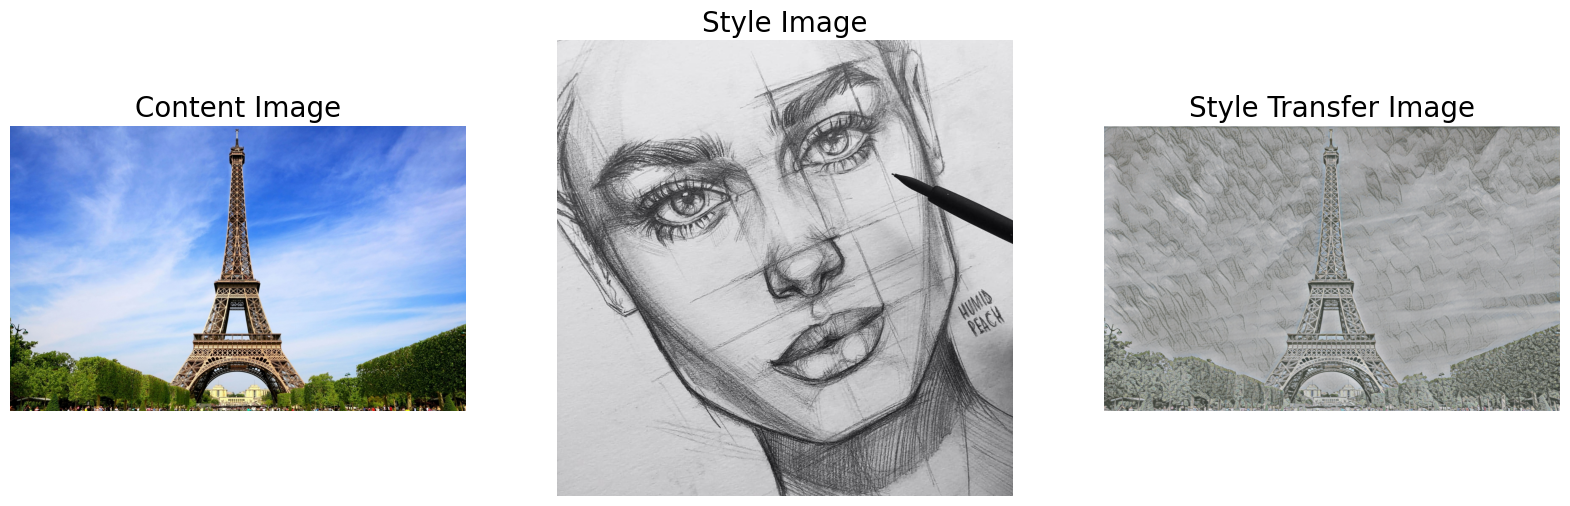

In [93]:
content_image_path = 'paris.jpg'
content_image = plt.imread(content_image_path)

style_image = plt.imread('style1.jpg')
result = pipeline.transform((content_image, style_image))


plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.title('Content Image', fontsize=20)
plt.imshow(content_image)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Style Image', fontsize=20)
plt.imshow(style_image)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Style Transfer Image', fontsize=20)
plt.imshow(result)
plt.axis('off')
plt.show()

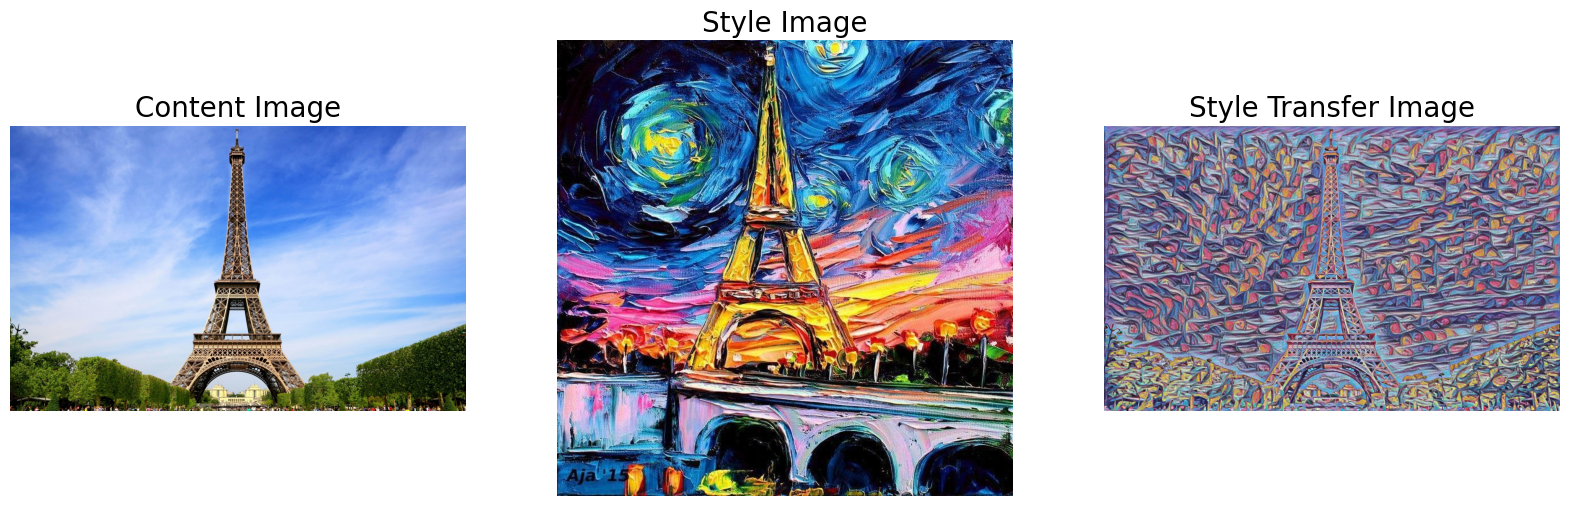

In [92]:
content_image_path = 'paris.jpg'
content_image = plt.imread(content_image_path)

style_image = plt.imread('style2.jpg')
result = pipeline.transform((content_image, style_image))


plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.title('Content Image', fontsize=20)
plt.imshow(content_image)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Style Image', fontsize=20)
plt.imshow(style_image)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Style Transfer Image', fontsize=20)
plt.imshow(result)
plt.axis('off')
plt.show()

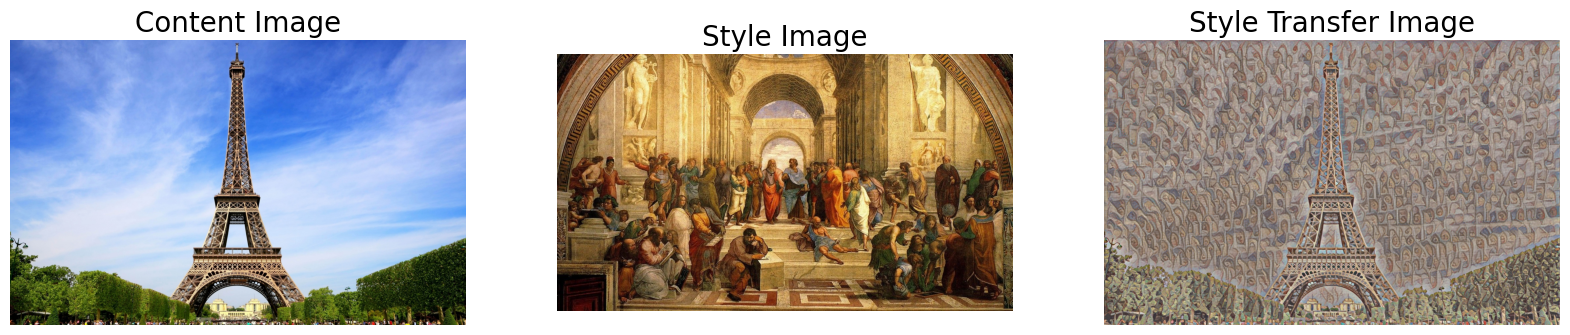

In [94]:
content_image_path = 'paris.jpg'
content_image = plt.imread(content_image_path)

style_image = plt.imread('style3.jpg')
result = pipeline.transform((content_image, style_image))


plt.figure(figsize=(20, 20))
plt.subplot(1,3,1)
plt.title('Content Image', fontsize=20)
plt.imshow(content_image)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Style Image', fontsize=20)
plt.imshow(style_image)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Style Transfer Image', fontsize=20)
plt.imshow(result)
plt.axis('off')
plt.show()

## Video

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [96]:
class LoadImage(BaseEstimator, TransformerMixin):
    def transform(self, X):
        image = plt.imread(X)
        image = image.astype(np.float32)[np.newaxis, ...] / 255.0
        return image

class StyleTransfer(BaseEstimator, TransformerMixin):
    def __init__(self, output_path):
        self.model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
        self.output_path = output_path

    def stylize(self, content, style_image):
        stylized_image = self.model(tf.constant(content), tf.constant(style_image))[0]
        return stylized_image

    def transform(self, video_path, style_image):
        cap = cv2.VideoCapture(video_path)

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Total number of frames: {total_frames}")

        result = cv2.VideoWriter(self.output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

        start_time = time.time()
        frame_count = 1
        while cap.isOpened():
            frame_start_time = time.time()
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype(np.float32)[np.newaxis, ...] / 255.

            stylized_frame = self.stylize(frame, style_image)
            stylized_frame = np.squeeze(stylized_frame)
            stylized_frame = (stylized_frame * 255).astype(np.uint8)
            stylized_frame = cv2.cvtColor(stylized_frame, cv2.COLOR_RGB2BGR)

            frame_end_time = time.time()
            frame_elapsed_time = frame_end_time - frame_start_time

            sys.stdout.write(f"\rFrame {frame_count}/{total_frames}: {frame_elapsed_time:.2f} seconds")
            sys.stdout.flush()
            frame_count += 1

            result.write(stylized_frame)

        end_time = time.time()
        total_elapsed_time = end_time - start_time

        print(f"Total processing time: {total_elapsed_time/60:.2f} minutes -/ total_frames")

        cap.release()
        result.release()

        return result

In [103]:
video_path = 'stork.mp4'
style_image_path = 'style1.jpg'
output_video_path = 'result_ST.mp4'

In [104]:
pipeline = Pipeline([
    ('image_loader',LoadImage()),
    ('style_transfer', StyleTransfer(output_path = output_video_path))
])

In [105]:
style_image = pipeline.named_steps['image_loader'].transform(style_image_path)
result = pipeline.named_steps['style_transfer'].transform(video_path, style_image)

Total number of frames: 278
Frame 278/278: 0.66 secondsTotal processing time: 3.32 minutes -/ total_frames
